# Learing pipeline

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Feb2022; March2022 


## 1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

### 1.1 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### 1.2 References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from typing import Dict, List, Tuple


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.learning_misc import train_loop, test_loop, basicVGGNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files//users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)
    
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )

PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files//users_paths_files/config_users_paths_files_username_mx19.yml


### 2.2 Setting variables and loading datasets using pytorch dataloader

In [2]:
# device = torch.device(if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cuda:NN" can also be used
print(f'Device: {device}')


# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=config['pretransform_im_size']),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


#### 80% of total datasets
train_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=train_transform,
    use_tmp_storage=True,
    )

#### 20% of total datasets
validation_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=val_transform,
    use_tmp_storage=True,
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.8

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(Ntrain, Ntest, Ntrain+Ntest)
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])



Device: cuda
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-074/T3/01NVb-003-074-3-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T1/01NVb-003-077-1-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T2/01NVb-003-077-2-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T3/01NVb-003-077-3-4CV.json (empty). Removing from list
58 14 72


### 2.3 Plotting Class Distribution


{'BKGR': 30, '4CV': 28}
{'BKGR': 6, '4CV': 8}
{'BKGR': 8, '4CV': 8}


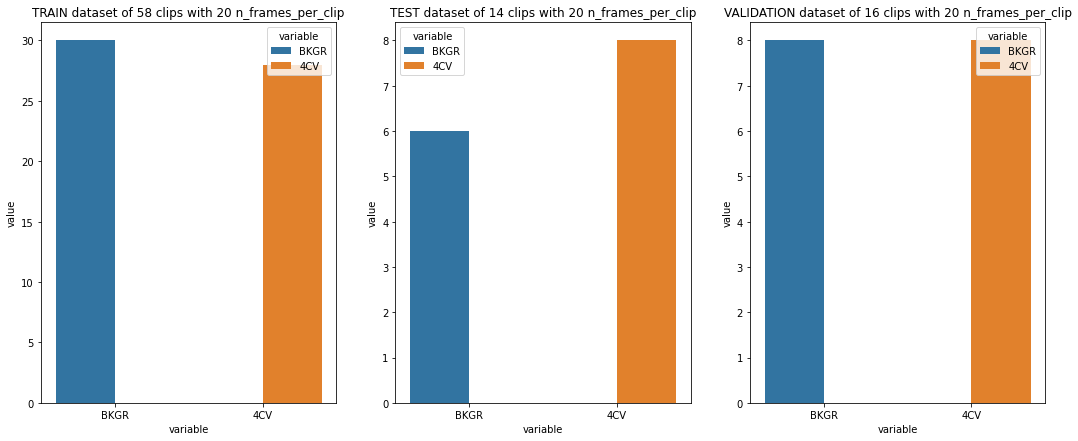

In [3]:
label_id = ('BKGR', '4CV')
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip'] 

def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


print(get_class_distribution(train_set))
print(get_class_distribution(test_set))
print(get_class_distribution(validation_dataset))

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(get_class_distribution(train_set), plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(get_class_distribution(test_set), plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(get_class_distribution(validation_dataset), plot_title=plot_title_val_label, ax=axes[2])
plt.show()



### 2.4 Animating frames of one clip of the dataloader

In [4]:
# #average_HR =
# #fps = 30
# # 60 # beats per minute
# #Beats-per-minute: 60 BPM
# #Beats-per-second: 1 Hz
# #Cycle-per-second: 1 (Cycle/s)
#
# clip_idx = 50
# data_clip_idx = train_set[clip_idx][0]
# data_clip_label = train_set[clip_idx][1]
# print(f'Clip Size of data_clip_idx {data_clip_idx.size()} of {label_id[data_clip_label]} label')
#
# ### Animating data_clip_idx
# interval_between_frames_in_milliseconds=200
# fig = plt.figure(figsize=(10, 10))
# frames = [[plt.imshow(data_clip_idx[i].cpu().detach().numpy().transpose(1, 2, 0))] for i in range(len(data_clip_idx))]
# anim = animation.ArtistAnimation(fig, frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)
#
# HTML(anim.to_jshtml())
#
# # ### Save animation as gif (if required) or other formats https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# # f = r"/home/mx19/repositories/echocardiography/scripts/learning-pipeline/animation.gif"
# # writergif = animation.PillowWriter(fps=30)
# # writergif2='imagemagick'
# # anim.save(f, dpi=80, writer=writergif)


### 2.6 Displayting frames in the dataloader

In [5]:
##############################
##### Setting up BATCH_SIZE_OF_CLIPS
BATCH_SIZE_OF_CLIPS = 4
##############################
##############################

print(f' train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)

print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'        Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'        Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()



 train_dataset.__len__() = 58
 test_dataset.__len__() = 14
 validation_dataset.__len__() = 16
len(train_dataloader): 15
    BATCH_OF_CLIPS_INDEX : 0 / 14
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 20, 1, 64, 64])
        BATCH_SIZE_IDX 0 label: 0
        Sample_batched_idx_image.size()  torch.Size([20, 1, 64, 64])
        Grid size torch.Size([3, 200, 530])
        BATCH_SIZE_IDX 1 label: 1
        Sample_batched_idx_image.size()  torch.Size([20, 1, 64, 64])
        Grid size torch.Size([3, 200, 530])
        BATCH_SIZE_IDX 2 label: 1
        Sample_batched_idx_image.size()  torch.Size([20, 1, 64, 64])
        Grid size torch.Size([3, 200, 530])
        BATCH_SIZE_IDX 3 label: 1
        Sample_batched_idx_image.size()  torch.Size([20, 1, 64, 64])
        Grid size torch.Size([3, 200, 530])
    BATCH_OF_CLIPS_INDEX : 1 / 14
    sample_batched_labels.size(): torch.Size([4])

### 2.5 Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch


In [6]:
## Define VGG architecture
class basicVGGNet(nn.Module):

    def __init__(self, tensor_shape_size, n_classes=2, cnn_channels=(1, 16, 32)):
        """
        Simple Visual Geometry Group Network (VGGNet) to classify two US image classes (background and 4CV).

        Args:
            tensor_shape_size: [Batch_clips, Depth, Channels, Height, Depth]

        """
        super(basicVGGNet, self).__init__()
        self.name = 'basicVGGNet'

        self.tensor_shape_size = tensor_shape_size
        self.n_classes = n_classes

        # define the CNN
        self.n_output_channels = cnn_channels ##  self.n_output_channels::: (1, 16, 32)
        self.kernel_size = (3, ) * (len(cnn_channels) -1) ## self.kernel_size::: (3, 3)

        self.n_batch_size_of_clip_numbers = self.tensor_shape_size[0]
        self.n_frames_per_clip = self.tensor_shape_size[1]
        self.n_number_of_image_channels = self.tensor_shape_size[2]
        self.input_shape_tensor = self.n_batch_size_of_clip_numbers * self.n_frames_per_clip * self.n_number_of_image_channels

        self.conv1 = nn.Conv3d(in_channels=self.n_number_of_image_channels, out_channels=64,
                               kernel_size=(1, 1, 1), stride=(1, 1, 1), padding = (0, 0, 0)
                               )
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=2,
                               kernel_size=(1, 1, 1), stride=(1, 1, 1), padding = (0, 0, 0)
                               )
                    #IN: [N,Cin,D,H,W]; OUT: (N,Cout,Dout,Hout,Wout)
                    #[batch_size, channels, depth, height, width].

        self.pool0 = nn.MaxPool3d(kernel_size=(60, 128, 128), stride=(1, 1, 1), padding=(0, 0, 0), dilation=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(0, 0, 0))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0))
        self.pool3 = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(0, 0, 0))
        self.pool4 = nn.MaxPool3d(kernel_size=(16, 16, 16), stride=(16, 16, 16), padding=(0, 0, 0))
        self.pool5 = nn.MaxPool3d(kernel_size=(32, 32, 32), stride=(32, 32, 32), padding=(0, 0, 0))
        self.pool6 = nn.MaxPool3d(kernel_size=(30, 30, 30), stride=(30, 30, 30), padding=(0, 0, 0))
        self.pool7 = nn.MaxPool3d(kernel_size= 60, stride= 60, padding=0)
        self.pool8 = nn.MaxPool3d(kernel_size=(64, 64, 64), stride=(64, 64, 64), padding=(0, 0, 0))
        self.pool9 = nn.MaxPool3d(kernel_size=(128, 128, 128), stride=(128, 128, 128), padding=(0, 0, 0))

        self.bn1 = nn.BatchNorm3d(num_features = 64)
        self.bn2 = nn.BatchNorm3d(num_features = 12)

        self.flatten = nn.Flatten()
        self.fc0 = nn.Linear(in_features=10, out_features=self.n_classes)
        self.fc1 = nn.Linear(in_features=62914560, out_features=self.n_classes)



    def forward(self, x):
        x = torch.permute(x, (0, 2, 1, 3, 4)) ##[batch_size, channels, depth, height, width]
        #print(f'x.shape(): {x.size()}') #x.shape(): torch.Size([10, 1, 60, 128, 128])

        #x = F.relu(self.bn1(self.conv1(x)))
        #x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv1(x))
        #print(f'x.shape(): {x.size()}')
        x = F.relu(self.conv2(x))
        #print(f'x.shape():: {x.size()}')
        x = self.pool0(x)
        #print(f'x.shape()::: {x.size()}')

        x = self.flatten(x)
        #print(f"After flattening, x.shape: {x.shape}")

        # x = x.reshape(x.shape[0], -1)
        # x = F.dropout(x, p=0.5) #dropout was included to combat overfitting
        #x = self.fc0(x)
        #print(f"After fc1, x.shape: {x.shape}")

        return x

    

class xNet(nn.Module):

    def __init__(self, input_size, n_classes=2):
        """
        Simple Video classifier to classify into two classes:
        Args:
            input_size:  shape of the input image. Should be a 2 element vector for a 2D video (width, height) [e.g. 128, 128].
            n_classes: number of output classes
        """

        super(xNet, self).__init__()
        self.name = 'xNet'
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_frames_per_clip = 60
        self.n_features = np.prod(self.input_size)*self.n_frames_per_clip

        
                
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=self.n_features, out_features=32),
#             nn.ReLU(),
#             nn.Linear(in_features=32, out_features=self.n_classes),
#             nn.Sigmoid()
#         )

        
        

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.conv0 = nn.Conv3d(in_channels=1, out_channels=64,
                               kernel_size=(1, 1, 1),  ## (-depth, -height, -width)
                               stride=(2, 2, 2), ##(depth/val0, height/val1, width/val2)
                               padding = (0, 0, 0)
                               )
        self.conv1 = nn.Conv3d(in_channels=64, out_channels=32,
                               kernel_size=(1, 1, 1),  # (-depth, -height, -width)
                               stride=(2, 2, 2), ##(depth/val0, height/val1, width/val2)
                               padding = (0, 0, 0)
                               )
        
#         self.pool0 = nn.MaxPool3d(kernel_size=(1, 100, 100),  # (-depth, -height, -width)
#                                   stride=(1, 1, 1), 
#                                   padding=(0, 0, 0), 
#                                   dilation=(1, 1, 1)
#                                  )

        self.fc0 = nn.Linear(in_features=40960, out_features=500)
        #self.fc1 = nn.Linear(in_features=10000, out_features=200)
        self.fc2 = nn.Linear(in_features=500, out_features=self.n_classes)
        

    def forward(self, x):
        ###x = self.classifier(x)

        x = torch.permute(x, (0, 2, 1, 3, 4)) ## -> [batch_size, channels, depth, height, width]
        
        x = F.relu( self.conv0(x) )
        #print(f'x.shape(): {x.size()}') #x.shape(): x.shape(): torch.Size([2, 64, 60, 128, 128]) with kernel_size=(1, 1, 1)
        #print(f'x.shape(): {x.size()}') #x.shape():torch.Size([2, 64, 51, 29, 29]) with kernel_size=(10, 100, 100)
        #print(f'conv0.size(): {x.size()}')
        
        x = F.relu( self.conv1(x) )
        #print(f'x.shape(): {x.size()}') with kernel_size=(1, 10, 10) #x.shape(): torch.Size([2, 32, 60, 20, 20])
        #print(f'conv1.size(): {x.size()}')
        
        #x = self.pool0(x)
        #print(f'x.pool0..shape(): {x.size()}') 
        
        x = self.flatten(x)
        #print(f'self.flatten(x) size() {x.size()}') #x.shape(): torch.Size([4, 983040])
        x = self.fc0(x)
        #print(f'x.shape(): {x.size()}') #x.shape(): torch.Size([4, 32])
        #x = F.relu(self.fc1(x))
        
        #print(f'x.shape(): {x.size()}') # x.shape(): torch.Size([4, 2])
        x = self.sigmoid(x)
        x = F.dropout(x, p=0.5) #dropout was included to combat overfitting
        x = self.fc2(x)
        #print(f'x.shape(): {x.size()}')  #x.shape(): torch.Size([4, 2])

        return x

In [7]:
##################################################################
##################################################################
##################################################################
##### Setting up Model Parameters
LEARNING_RATE = 0.000005
MAX_EPOCHS = 500 #Alternatvely, make use of: config['max_epochs']
##################################################################
##################################################################
##################################################################


##### Sanity Checks
#tensor_shape_size = [BATCH_SIZE_OF_CLIPS, config['number_of_frames_per_segment_in_a_clip'], 1, 128, 128]
#model = basicVGGNet(tensor_shape_size)

model = xNet(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
model.to(device) # Place model on GPU-

### Sanity check
#print(len(train_dataloader)) #6 BATCHES of 10=BATCH_SIZE_OF_CLIPS
sample_batched = next(iter(train_dataloader))
#print(sample_batched[0].shape) #torch.Size([10, 60, 1, 128, 128])
#print(sample_batched[1])#tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])
#print(sample_batched[2]) #tensor([47, 42,  0, 51, 49, 75, 67, 67, 62, 84])
#print(sample_batched[3]) #tensor([105, 102,  43, 106,  94, 161, 151, 183, 150, 151])

clip_batch = sample_batched[0]

# frames = image.to(device)
# #
# # ###Sanity check-
model(clip_batch).shape
#print(model(clip_batch).shape) #torch.Size([10, 1, 60, 128, 128])



torch.Size([4, 2])

In [8]:
#https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
#del sample_batched
torch.cuda.empty_cache()

In [9]:

#model = basicVGGNet(tensor_shape_size)
#model.to(device)

model = xNet(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
model.to(device) # Place model on GPU-


## PRINT MODEL
print(f'====================================================')
print(model)

# ### PRINT model.named_parameters
# print(f'====================================================')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)


optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()



xNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (conv0): Conv3d(1, 64, kernel_size=(1, 1, 1), stride=(2, 2, 2))
  (conv1): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=(2, 2, 2))
  (fc0): Linear(in_features=40960, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)


### 2.7 Training loop

In [10]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    #'train': [],
    'test': [],
    #"val": []
}

#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    #train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc = train_validation_loop(train_dataloader, val_dataloader, model, criterion, optimizer, device)
    #train_epoch_loss, train_epoch_acc = 
    train_epoch_loss = train_loop(train_dataloader, model, criterion, optimizer, device)
    model.eval()
    test_epoch_loss, correct = test_loop(val_dataloader, model, criterion, device)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} ')
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)    
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")



model_path = '/home/mx19/tmp/model' 
print(f' {model_path}')
torch.save(model.state_dict(), os.path.join(model_path, "metric_model.pth"))
print("Saved metric model")


print(loss_stats)
print(accuracy_stats)


----------
EPOCH 1/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 00: | Average Train Loss: 0.686 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.730875 

----------
EPOCH 2/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 01: | Average Train Loss: 0.739 
Test Error: 
 Test Accur

 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 16: | Average Train Loss: 0.743 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.741407 

----------
EPOCH 18/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 17: | Average Train Loss: 0.641 
Test Error: 
 Test Accuracy: 56.2%, Avg Test l

 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 32: | Average Train Loss: 0.733 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.756351 

----------
EPOCH 34/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 33: | Average Train Loss: 0.733 
Test Error: 
 Test Accuracy: 31.2%, Avg Test loss: 0.807086 

----------
EPOCH 35/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CL

 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 48: | Average Train Loss: 0.723 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.690550 

----------
EPOCH 50/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 49: | Average Train Loss: 0.718 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.722734 

----------
EPOCH 51/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CL

 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 64: | Average Train Loss: 0.716 
Test Error: 
 Test Accuracy: 43.8%, Avg Test loss: 0.721836 

----------
EPOCH 66/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 65: | Average Train Loss: 0.741 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.725332 

----------
EPOCH 67/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CL

 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 80: | Average Train Loss: 0.683 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.703694 

----------
EPOCH 82/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 81: | Average Train Loss: 0.691 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.708567 

----------
EPOCH 83/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CL

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 96: | Average Train Loss: 0.679 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.702041 

----------
EPOCH 98/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 97: | Average Train Loss: 0.679 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.688751 

----------
EPOCH 99/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CL

 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 112: | Average Train Loss: 0.733 
Test Error: 
 Test Accuracy: 31.2%, Avg Test loss: 0.770283 

----------
EPOCH 114/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 113: | Average Train Loss: 0.695 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.686972 

----------
EPOCH 115/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 128: | Average Train Loss: 0.733 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.748477 

----------
EPOCH 130/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 129: | Average Train Loss: 0.695 
Test Error: 
 Test Accuracy: 43.8%, Avg Test loss: 0.734588 

----------
EPOCH 131/500
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 144: | Average Train Loss: 0.695 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.673676 

----------
EPOCH 146/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 145: | Average Train Loss: 0.665 
Test Error: 
 Test Accuracy: 31.2%, Avg Test loss: 0.746528 

-------

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 160: | Average Train Loss: 0.700 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.677547 

----------
EPOCH 162/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 161: | Average Train Loss: 0.695 
Test Error: 
 Test Accuracy: 43.8%, Avg Test loss: 0.724875 

----------
EPOCH 163/500
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 176: | Average Train Loss: 0.729 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.654590 

----------
EPOCH 178/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 177: | Average Train Loss: 0.683 
Test Error: 
 Test Accuracy: 31.2%, Avg Test loss: 0.724498 

----------
EPOCH 179/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 192: | Average Train Loss: 0.684 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.672798 

----------
EPOCH 194/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 193: | Average Train Loss: 0.671 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.723689 

----------
EPOCH 195/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 208: | Average Train Loss: 0.674 
Test Error: 
 Test Accuracy: 43.8%, Avg Test loss: 0.720788 

----------
EPOCH 210/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 209: | Average Train Loss: 0.737 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.698452 

----------
EPOCH 211/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 224: | Average Train Loss: 0.692 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.683534 

----------
EPOCH 226/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 225: | Average Train Loss: 0.688 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.664091 

----------
EPOCH 227/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 240: | Average Train Loss: 0.691 
Test Error: 
 Test Accuracy: 31.2%, Avg Test loss: 0.746689 

----------
EPOCH 242/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 241: | Average Train Loss: 0.690 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.673428 

----------
EPOCH 243/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 256: | Average Train Loss: 0.682 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.687719 

----------
EPOCH 258/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 257: | Average Train Loss: 0.697 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.670138 

----------
EPOCH 259/500
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 272: | Average Train Loss: 0.693 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.749012 

----------
EPOCH 274/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 273: | Average Train Loss: 0.696 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.656303 

----------
EPOCH 275/500
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 288: | Average Train Loss: 0.690 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.695640 

----------
EPOCH 290/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 289: | Average Train Loss: 0.676 
Test Error: 
 Test Accuracy: 56.2%, Avg Tes

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 304: | Average Train Loss: 0.687 
Test Error: 
 Test Accuracy: 43.8%, Avg Test loss: 0.700297 

----------
EPOCH 306/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 305: | Average Train Loss: 0.720 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.656279 

----------
EPOCH 307/500
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 320: | Average Train Loss: 0.707 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.705428 

----------
EPOCH 322/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 321: | Average Train Loss: 0.685 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.725035 

----------
EPOCH 323/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 336: | Average Train Loss: 0.656 
Test Error: 
 Test Accuracy: 43.8%, Avg Test loss: 0.739741 

----------
EPOCH 338/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 337: | Average Train Loss: 0.697 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.674973 

----------
EPOCH 339/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 352: | Average Train Loss: 0.693 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.735727 

----------
EPOCH 354/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 353: | Average Train Loss: 0.667 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.701143 

----------
EPOCH 355/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 368: | Average Train Loss: 0.682 
Test Error: 
 Test Accuracy: 81.2%, Avg Test loss: 0.637017 

----------
EPOCH 370/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 369: | Average Train Loss: 0.671 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.702911 

----------
EPOCH 371/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 384: | Average Train Loss: 0.680 
Test Error: 
 Test Accuracy: 43.8%, Avg Test loss: 0.699594 

----------
EPOCH 386/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 385: | Average Train Loss: 0.698 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.667245 

----------
EPOCH 387/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 400: | Average Train Loss: 0.707 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.704887 

----------
EPOCH 402/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 401: | Average Train Loss: 0.693 
Test Error: 
 Test Accuracy: 68.8%, Avg Test loss: 0.655472 

----------
EPOCH 403/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 416: | Average Train Loss: 0.686 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.698644 

----------
EPOCH 418/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 417: | Average Train Loss: 0.695 
Test Error: 
 Test Accuracy: 81.2%, Avg Test loss: 0.614651 

----------
EPOCH 419/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 432: | Average Train Loss: 0.679 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.688821 

----------
EPOCH 434/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 433: | Average Train Loss: 0.657 
Test Error: 
 Test Accuracy: 62.5%, Avg Test loss: 0.701191 

----------
EPOCH 435/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 448: | Average Train Loss: 0.675 
Test Error: 
 Test Accuracy: 75.0%, Avg Test loss: 0.626551 

----------
EPOCH 450/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 449: | Average Train Loss: 0.706 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.678410 

----------
EPOCH 451/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 464: | Average Train Loss: 0.705 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.727181 

----------
EPOCH 466/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 465: | Average Train Loss: 0.680 
Test Error: 
 Test Accuracy: 31.2%, Avg Test loss: 0.710739 

----------
EPOCH 467/500
 BATCH_O

 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 480: | Average Train Loss: 0.698 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.715551 

----------
EPOCH 482/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 481: | Average Train Loss: 0.676 
Test Error: 
 Test Accuracy: 31.2%, Avg Tes

 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 496: | Average Train Loss: 0.699 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.688373 

----------
EPOCH 498/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
 BATCH_OF_CLIPS_INDEX: 6 
 BATCH_OF_CLIPS_INDEX: 7 
 BATCH_OF_CLIPS_INDEX: 8 
 BATCH_OF_CLIPS_INDEX: 9 
 BATCH_OF_CLIPS_INDEX: 10 
 BATCH_OF_CLIPS_INDEX: 11 
 BATCH_OF_CLIPS_INDEX: 12 
 BATCH_OF_CLIPS_INDEX: 13 
 BATCH_OF_CLIPS_INDEX: 14 
Epoch 497: | Average Train Loss: 0.691 
Test Error: 
 Test Accuracy: 56.2%, Avg Test loss: 0.671723 

----------
EPOCH 499/500
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_O

## 2.8 Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Accuracy/Epoch EPOCHS=500 BATCH_SIZE_OF_CLIPS=4 LEARNING_RATE=5e-06')

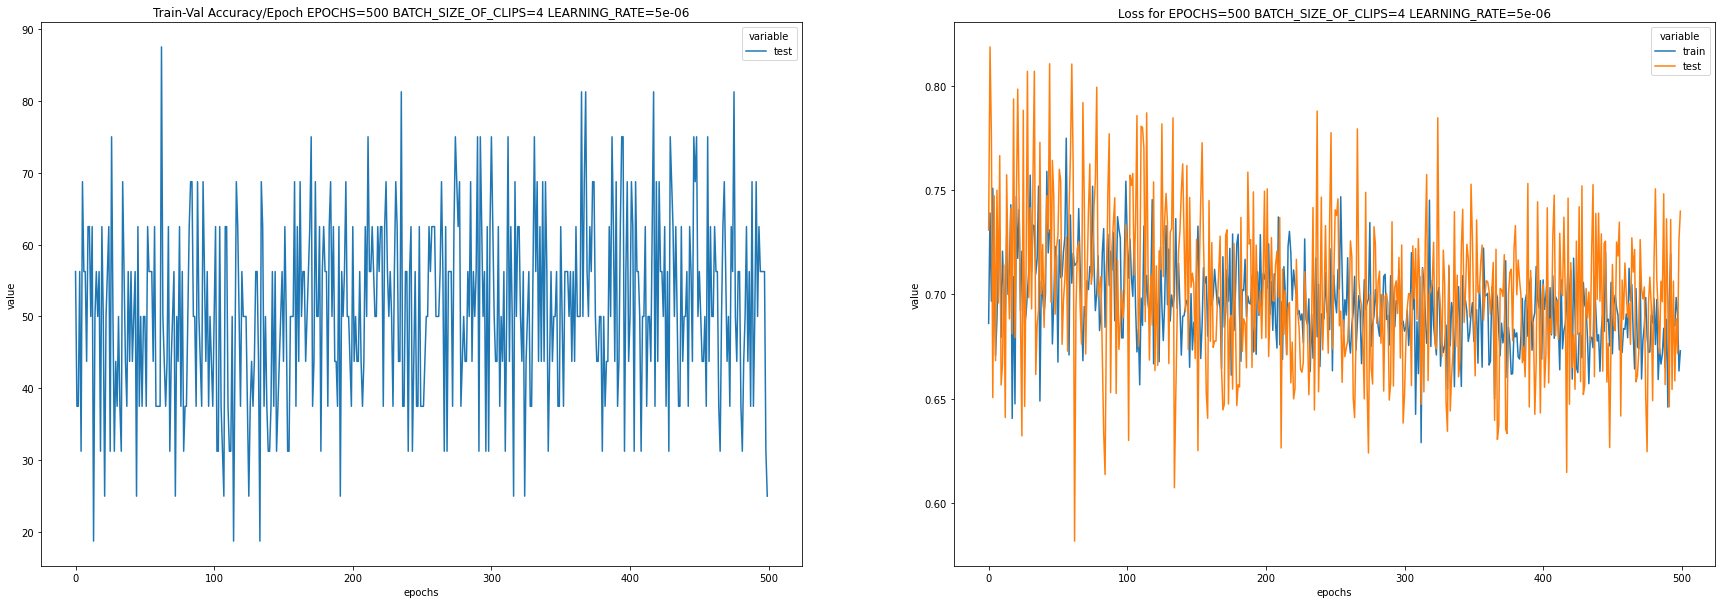

In [11]:

loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(f'Loss for EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')
sns.lineplot(data=acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Train-Val Accuracy/Epoch EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')


                     


## 3. Evaluate the model on test dataset

In [12]:
model.load_state_dict(torch.load(
    os.path.join(model_path, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
        
print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')





 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([4, 20, 1, 64, 64])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([4, 20, 1, 64, 64])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 2 
   X_train_batch.size(): torch.Size([4, 20, 1, 64, 64])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 3 
   X_train_batch.size(): torch.Size([2, 20, 1, 64, 64])
   y_train_batch.size(): torch.Size([2])
y_pred_list[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]
y_true_list[0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]


              precision    recall  f1-score   support

           0       0.38      0.50      0.43         6
           1       0.50      0.38      0.43         8

    accuracy                           0.43        14
   macro avg       0.44      0.44      0.43        14
weighted avg       0.45      0.43      0.43        14

[[3 3]
 [5 3]]


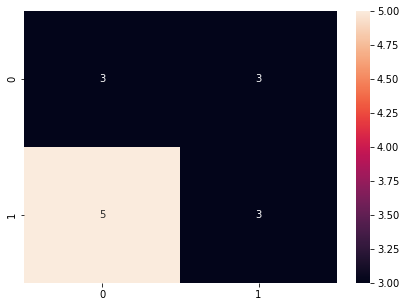

In [13]:

print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list))

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()


## Cleanup data directory
Remove directory if a temporary was used.

In [14]:
if model_path is None:
   shutil.rmtree(model_path)


In [15]:
## BLURS

#class BasicCNNClassifier(nn.Module):
#
# ....
#
#     def forward(self, x):
#         x = self.classifier(x)
#         #print(f'  x.size():::::::  {x.size()}')  #   x.size():::::::  torch.Size([2, 2])
#         #print(x)
#         #tensor([[0.1271, 0.6632],
#         #        [0.3063, 0.5489]], device='cuda:0', grad_fn= < SigmoidBackward >)
#         return x

    
##class basicVGGNet(nn.Module):
#
# ....
#
#     def forward(self, x):
#         #print(f'  x.size():  {x.size()}') # torch.Size([2, 60, 1, 128, 128])  BATCH_SIZE_OF_CLIPS, frames, channels, [width, height]
#         # x = torch.permute(x, (0, 2, 1, 3, 4)) ##[batch_size, channels, depth, height, width]
#         x = torch.permute(x, (2, 0, 1, 3, 4)) ##[channels, batch_size, depth, height, width]
#         #print(f'  x.size()::  {x.size()}')  #  x.size()::  torch.Size([1, 2, 60, 128, 128])

#         x = F.relu(self.conv1(x))
#         #print(f'  x.size():::  {x.size()}') #  x.size():::  torch.Size([1, 64, 60, 128, 128])
#         x = self.maxpool3d(x)
#         #print(f'  x.size()::::  {x.size()}') #  x.size()::::  torch.Size([1, 64, 60, 128, 128])
#         x = x.reshape(x.shape[0], -1)
#         #print(f'  x.size():::::  {x.size()}') #  x.size():::::  torch.Size([1, 62914560])
#         x = F.dropout(x, p=0.5) #dropout was included to combat overfitting
#         #print(f'  x.size()::::::  {x.size()}') #  x.size()::::::  torch.Size([1, 62914560])

#         x = self.fc1(x)
#         #print(f'  x.size():::::::  {x.size()}') #  x.size():::::::  torch.Size([1, 2])

#         return x